# Using RNNs and LSTMs to predict discharge curves of later cycles from those of earlier cycles

## Importing libraries and defining parameters

In [104]:
import tensorflow as tf 
from tensorflow import keras
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import modules.utils as tools

In [105]:
window_size = 10
forecasting_range = 50
dimensionality = 230
cutoff = 5

## Data preprocessing

In [106]:
import pickle
with open('Data/pickles/interpolated_data.pkl', 'rb') as f:
    interpolated_data = pickle.load(f)
    #times =interpolated_data[battery_no][cycle_no][:,0]

In [107]:
interpolated_data = np.array(interpolated_data)

/tmp/ipykernel_4242/580606031.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  interpolated_data = np.array(interpolated_data)


In [108]:
def clip_interpolated_data(cutoff, interpolated_data):
    for i in range(3):
        for j in range(168):
            interpolated_data[i,j] = interpolated_data[i, j][cutoff:,:]
    return interpolated_data.tolist()

In [109]:
interpolated_data = clip_interpolated_data(cutoff, interpolated_data)

In [110]:
minimum = 1.7555322021036255
maximum = 4.2331462538907605

def min_max_scaling(all_data, minimum = 1.7555322021036255, maximum = 4.2331462538907605):
    return (all_data - minimum)/(maximum-minimum)

def inverse_min_max_scaling(scaled_data, minimum = 1.7555322021036255, maximum = 4.2331462538907605):
    return (scaled_data)*(maximum-minimum) + minimum

interpolated_data = np.array(interpolated_data)
interpolated_data = min_max_scaling(interpolated_data).tolist()

/tmp/ipykernel_4242/741292086.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  interpolated_data = np.array(interpolated_data)


In [111]:
num_examples = len(interpolated_data[0]) - window_size - forecasting_range
X_5 = np.empty((num_examples, window_size, dimensionality))
Y_5 = np.empty((num_examples, forecasting_range, dimensionality))
for i in range(num_examples):
    for j in range(window_size):
        X_5[i, j, :] = interpolated_data[0][i+j][:,1][:dimensionality]
    for k in range(forecasting_range):
        Y_5[i, k, :] = interpolated_data[0][i+k+window_size][:,1][:dimensionality]
    

In [112]:
num_examples = len(interpolated_data[1]) - window_size - forecasting_range
X_6 = np.empty((num_examples, window_size, dimensionality))
Y_6 = np.empty((num_examples, forecasting_range, dimensionality))
for i in range(num_examples):
    for j in range(window_size):
        X_6[i, j, :] = interpolated_data[1][i+j][:,1][:dimensionality]
    for k in range(forecasting_range):
        Y_6[i, k, :] = interpolated_data[1][i+k+window_size][:,1][:dimensionality]

In [113]:
num_examples = len(interpolated_data[2]) - window_size - forecasting_range
X_7 = np.empty((num_examples, window_size, dimensionality))
Y_7 = np.empty((num_examples, forecasting_range, dimensionality))
for i in range(num_examples):
    for j in range(window_size):
        X_7[i, j, :] = interpolated_data[2][i+j][:,1][:dimensionality]
    for k in range(forecasting_range):
        Y_7[i, k, :] = interpolated_data[2][i+k+window_size][:,1][:dimensionality]

## Train-test split

In [114]:
from sklearn.model_selection import train_test_split
X_5_train, X_5_test, Y_5_train, Y_5_test = train_test_split(X_5, Y_5, random_state = 42, train_size = 0.8)
X_6_train, X_6_test, Y_6_train, Y_6_test = train_test_split(X_6, Y_6, random_state = 42, train_size = 0.8)
X_7_train, X_7_test, Y_7_train, Y_7_test = train_test_split(X_7, Y_7, random_state = 42, train_size = 0.8)

In [115]:
X_train = np.concatenate((X_5_train, X_6_train, X_7_train), axis = 0)
Y_train = np.concatenate((Y_5_train, Y_6_train, Y_7_train), axis = 0)
X_test = np.concatenate((X_5_test, X_6_test, X_7_test), axis = 0)
Y_test = np.concatenate((Y_5_test, Y_6_test, Y_7_test), axis = 0)

In [116]:
X_train_swapped = np.swapaxes(X_train, 1, 2)
X_test_swapped = np.swapaxes(X_test, 1, 2)
Y_train_swapped = np.swapaxes(Y_train, 1, 2)
Y_test_swapped = np.swapaxes(Y_test, 1, 2)

## Model building

In [117]:
## Custom loss function
## y_true, y_pred have dimensions (dimensionality x forecasting_range)
def weighted_loss(weights):
    def loss(y_true, y_pred):
        squared_difference = tf.math.square(y_true - y_pred)
        weighted_squared_difference = tf.math.multiply(squared_difference, weights)
        return tf.reduce_mean(weighted_squared_difference, axis=-1)
    return loss

### Trying out custom weights for loss function

In [159]:
# Weight the earlier cycles more heavily
row = np.linspace(start=1.5, stop=0.5, num=forecasting_range)
weights_1 = np.tile(row, (dimensionality, 1))
weights_1

array([[1.5       , 1.47959184, 1.45918367, ..., 0.54081633, 0.52040816,
        0.5       ],
       [1.5       , 1.47959184, 1.45918367, ..., 0.54081633, 0.52040816,
        0.5       ],
       [1.5       , 1.47959184, 1.45918367, ..., 0.54081633, 0.52040816,
        0.5       ],
       ...,
       [1.5       , 1.47959184, 1.45918367, ..., 0.54081633, 0.52040816,
        0.5       ],
       [1.5       , 1.47959184, 1.45918367, ..., 0.54081633, 0.52040816,
        0.5       ],
       [1.5       , 1.47959184, 1.45918367, ..., 0.54081633, 0.52040816,
        0.5       ]])

In [119]:
# Weight the earlier and later timesteps more heavily
column_1 = np.linspace(start = 1.5, stop= 0.5, num = int(dimensionality/2))
column_2 = np.linspace(start=0.5, stop=1.5, num = int(dimensionality/2))
column = np.concatenate((column_1, column_2), axis = 0)
column = column.reshape(-1, 1)
weights_2 = np.tile(column, (1, forecasting_range))

In [130]:
# Weight the later timesteps more heavily
column = np.linspace(start=0.5, stop=1.5, num = dimensionality)
column = column.reshape(-1, 1)
weights_3 = np.tile(column, (1, forecasting_range))

In [143]:
def create_model(loss,forecasting_range=50,window_size=10, n_neurons=100, additional_layers=1, activation='tanh', optimizer='Adam'):
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(n_neurons, input_shape=[None, window_size], activation=activation, return_sequences=True))
    for _ in range(additional_layers):
        model.add(keras.layers.LSTM(n_neurons, activation=activation, return_sequences=True))
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(forecasting_range)))
    model.compile(optimizer=optimizer, loss=loss)
    return model

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10),
    ]
#tf.keras.callbacks.TensorBoard(log_dir='./logs')
weights_1_model = create_model(loss=weighted_loss(weights_3), additional_layers=1)
#weights_1_model.load_weights('weights_1_predict_cycles.h5')
history = weights_1_model.fit(X_train_swapped, Y_train_swapped, epochs=1000, validation_data = (X_test_swapped, Y_test_swapped), callbacks=my_callbacks, verbose=1)


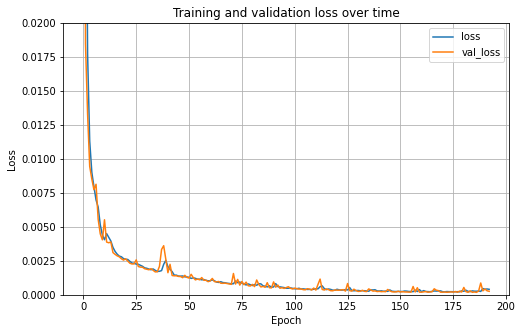

In [165]:
##Plotting training history

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,0.02)
plt.title('Training and validation loss over time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [148]:
#weights_1_model.save('weights_1_dim_230.h5')
weights_1_model.load_weights('h5_files/weights_1_dim_230.h5')


## Visualising results

In [166]:
def prepare_data_for_plot(model, X_5, X_6, X_7):
    X_5_swapped = np.swapaxes(X_5, 1, 2)
    Y_5_preds = np.swapaxes(model.predict(X_5_swapped), 1, 2)
    X_6_swapped = np.swapaxes(X_6, 1, 2)
    Y_6_preds = np.swapaxes(model.predict(X_6_swapped), 1, 2)
    X_7_swapped = np.swapaxes(X_7, 1, 2)
    Y_7_preds = np.swapaxes(model.predict(X_7_swapped), 1, 2)
    return Y_5_preds, Y_6_preds, Y_7_preds


In [167]:
Y_5_preds, Y_6_preds, Y_7_preds = prepare_data_for_plot(weights_1_model, X_5, X_6, X_7)

In [168]:
def plot_projections(X_data, Y_data, starting_cycle=0, step=20, is_actual=False, dimensionality=200):
    if is_actual:
        text = 'Actual'
    else:
        text = 'Projected'
    plt.figure
    plt.title(text + ' discharge curves for the next 50 cycles')
    plt.ylim(bottom=3, top=4)
    plt.xlabel('Time step (1 unit = 10s)')
    plt.ylabel('Voltage')
    x = np.arange(start=0, stop=dimensionality, step=1)
    for j in range(0,forecasting_range,step):
        voltages = inverse_min_max_scaling(Y_data[starting_cycle, j, :])
        plt.plot(x, voltages, color = 'green', label=text + ' next 50 cycles')
    for i in range(window_size):
        voltages = inverse_min_max_scaling(X_data[starting_cycle, i, :])
        plt.plot(x, voltages, color = 'orange', label='10 cycles')
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.show()

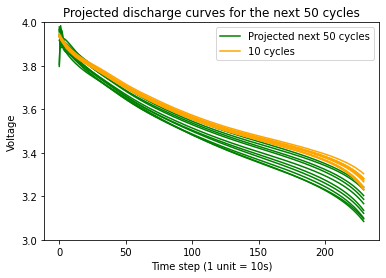

In [173]:
plot_projections(X_5, Y_5_preds, starting_cycle=100, step=5, dimensionality=dimensionality)

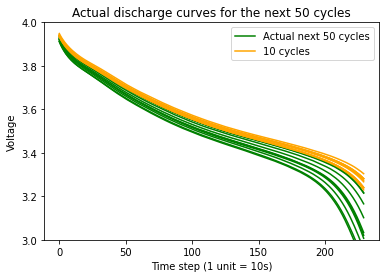

In [172]:
plot_projections(X_5, Y_5, starting_cycle=100, step=5, is_actual=True, dimensionality=dimensionality)

In [138]:
def create_comparison_plot(dimensionality=dimensionality, starting_cycle=0, cycle_number=0, battery_number=0):
    x = np.arange(start=0, stop=dimensionality, step=1)
    if battery_number == 0:
        plt.plot(x, inverse_min_max_scaling(Y_5[starting_cycle,cycle_number,:]), label='actual')
        plt.plot(x, inverse_min_max_scaling(Y_5_preds[starting_cycle,cycle_number,:]), label='prediction')
        battery_id = 'B0005'
    if battery_number == 1:
        plt.plot(x, inverse_min_max_scaling(Y_6[starting_cycle,cycle_number,:]), label='actual')
        plt.plot(x, inverse_min_max_scaling(Y_6_preds[starting_cycle,cycle_number,:]), label='prediction')
        battery_id = 'B0006'
    if battery_number == 2:
        plt.plot(x, inverse_min_max_scaling(Y_7[starting_cycle,cycle_number,:]), label='actual')
        plt.plot(x, inverse_min_max_scaling(Y_7_preds[starting_cycle,cycle_number,:]), label='prediction')
        battery_id = 'B0007'
    plt.xlabel('Timestep (1 unit = 10s)')
    plt.ylabel('Voltage')
    plt.title('Comparing actual to predicted curve for battery ' + battery_id + ', ' + str(cycle_number) + ' cycles starting from cycle #' + str(starting_cycle))
    plt.legend()
    plt.show()

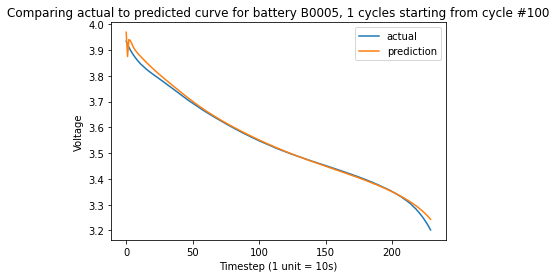

In [178]:
create_comparison_plot(starting_cycle=100, cycle_number=1, battery_number=0)

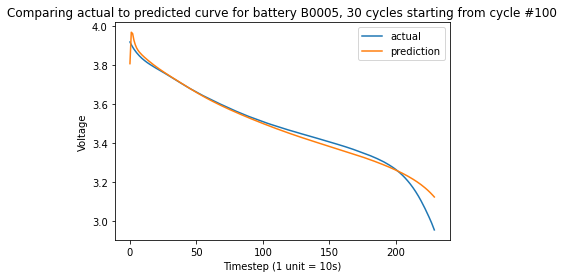

In [180]:
create_comparison_plot(starting_cycle=100, cycle_number=30, battery_number=0)